# Region Class Definition

## Setup

### Imports

In [1]:
from typing import List

# Shared Packages
import pandas as pd
from shapely.geometry import MultiPolygon, Polygon
import matplotlib.pyplot as plt

# Local functions and classes
from types_and_classes import *
from utilities import *
from debug_tools import *
from structure_slice import *
from structure_set import *
#from metrics import *
#from relations import *

### Global Settings

In [2]:
PRECISION = 2

In [3]:
%matplotlib inline

## Need to do boundary checks by region not by structure
- Make a Region class with the following attributes:
    - ROI: ROI_Type, 
    - slice: SliceIndexType, 
    - is_hole: bool,
    - is_boundary: bool,
    - region_labels: List[str], 
    - polygon: ContourType
- Step through all structures and separate each slice into individual polygons 
    and holes (Regions)
- Apply region labels, based on overlapping polygons.
  - Set unique labels for each region on the first slice: 'a', 'b' ...
  - find overlapping polygons on the next slice and give them the same 
      region labels.
  - A polygon can be in multiple regions.
- If a polygon in the current region is not matched to a polygon in the next 
    region, it is a boundary polygon.
- If a polygon in the next region is not matched with a polygon in the current 
    region, it is a boundary polygon. Assign it to a new region
- Store as a list of dictionaries with keys: ROI, slice, is_hole, polygon
- convert to a DataFrame and sort on ROI and slice


`object.relate_pattern(other, pattern)`
> Returns True if the *DE-9IM* string code for the relationship between the geometries satisfies the pattern, otherwise False.

- The `relate_pattern()` compares the *DE-9IM* code string for two geometries against a specified pattern. If the string matches the pattern then True is returned, otherwise False. 
- The pattern specified can be an exact match (`0`, `1` or `2`), a boolean match (`T` or `F`), or a wildcard (`*`). 
- For example, the pattern for the within predicate is `'T*****FF*'`.

```python
point = Point(0.5, 0.5)
square = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
square.relate_pattern(point, 'T*****FF*')
```

> True

`point.within(square)`

> True

Note that the order or the geometries is significant, as demonstrated below. In this example the square contains the point, but the point does not contain the square.

`point.relate(square)`

> '0FFFFF212'

`square.relate(point)`

> '0F2FF1FF2'

In [4]:
def dual_embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    middle_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole, middle_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [8]:
slice_table = dual_embedded_cylinder()

regions = generate_region_graph(slice_table)


# ERROR: Interpolated boundaries are not being linked to the correct nodes

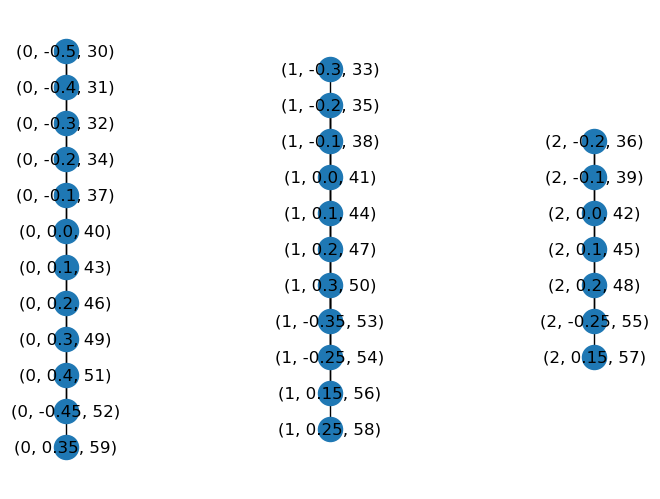

In [ ]:
pos = nx.multipartite_layout(regions, subset_key='roi')
nx.draw(regions, pos=pos, with_labels=True)

In [9]:
region_table = expand_region_table(regions_dict)
region_table.set_index(['ROI', 'Label', 'Slice'], inplace=True)
#region_table
a = region_table.unstack(['ROI', 'Label'])

In [10]:
def is_hole(region):
    if isinstance(region, Region):
        return region.is_hole
    return ''
a.map(is_hole)

Region                          
ROI        0      1                  2
Label      a      b     c     d      e
Slice                                 
-0.5   False                          
-0.4   False                          
-0.3   False  False                   
-0.2   False  False  True  True  False
-0.1   False  False  True  True  False
 0.0   False  False  True  True  False
 0.1   False  False  True  True  False
 0.2   False  False  True  True  False
 0.3   False  False                   
 0.4   False

In [11]:
def is_boundary(region):
    if isinstance(region, Region):
        return region.is_boundary
    return ''
a.map(is_boundary)

Region                            
ROI        0      1                    2
Label      a      b      c      d      e
Slice                                   
-0.5    True                            
-0.4   False                            
-0.3   False   True                     
-0.2   False  False   True   True   True
-0.1   False  False  False  False  False
 0.0   False  False  False  False  False
 0.1   False  False  False  False  False
 0.2   False  False   True   True   True
 0.3   False   True                     
 0.4    True

**Note:** The Last slice of Region 0 (Body) is not registering as a boundary
- Modify the code to include the last slice as a boundary